In [1]:
import numpy as np
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow import keras
import random
import tensorflow as tf

In [2]:
EPOCHS = 20
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
width=256
height=256
depth=3
root_directory = r"C:\Users\marti\Downloads\data_all\data_all"

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
try:
    print("Loading images...")

    
    #DIRECTORY 1
    poison_ivy = "poison_ivy"
    directory1 = root_directory + "\\" + poison_ivy    
    list_directory1 = listdir(directory1)
    
    for image in list_directory1[:200]:
        image_directory1 = f"{directory1}\\{image}"        
        if image_directory1.endswith(".jpg") == True or image_directory1.endswith(".JPG") == True:
            image_list.append(convert_image_to_array(image_directory1))
            label_list.append(poison_ivy)

    
    #DIRECTORY 2
    raspberry = "raspberry"
    directory2 = root_directory + "\\" + raspberry
    list_directory2 = listdir(directory2)
    
    for image in list_directory2[:]:
        image_directory2 = f"{directory2}\\{image}"
        if image_directory2.endswith(".jpg") == True or image_directory2.endswith(".JPG") == True:
            image_list.append(convert_image_to_array(image_directory2))
            label_list.append(raspberry)
    
    
    #DIRECTORY 3
    tomato = "tomato"
    directory3 = root_directory + "\\" + tomato
    list_directory3 = listdir(directory3)
    
    for image in list_directory3[:]:
        image_directory3 = f"{directory3}\\{image}"
        if image_directory3.endswith(".jpg") == True or image_directory3.endswith(".JPG") == True:
            image_list.append(convert_image_to_array(image_directory3))
            label_list.append(tomato)
    
    print("Image loading completed")
except Exception as e:
    print(f"Error : {e}")

Loading images...
Image loading completed


In [6]:
image_size = len(image_list)
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

print(f"Number of images: {image_size}")
print(f"Image classifications: {label_binarizer.classes_}")

Number of images: 700
Image classifications: ['poison_ivy' 'raspberry' 'tomato']


In [7]:
np_image_list = np.array(image_list, dtype=np.float16)

In [8]:
print("Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

Spliting data to train, test


In [9]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [10]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 85, 85, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 85, 85, 64)        2

In [11]:
#OPTIMIZE AND REDUCE LOSS
print("Optimizing and training network")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


Optimizing and training network


In [15]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=7, 
    verbose=1
    )

Epoch 1/7
17/17 [==============================] - 46s 3s/step - loss: 0.1849 - accuracy: 0.8769 - val_loss: 2.8322 - val_accuracy: 0.6714
Epoch 2/7
17/17 [==============================] - 47s 3s/step - loss: 0.1533 - accuracy: 0.9110 - val_loss: 1.0438 - val_accuracy: 0.7643
Epoch 3/7
17/17 [==============================] - 53s 3s/step - loss: 0.1359 - accuracy: 0.9191 - val_loss: 1.3963 - val_accuracy: 0.6071
Epoch 4/7
17/17 [==============================] - 56s 3s/step - loss: 0.1445 - accuracy: 0.9242 - val_loss: 0.6316 - val_accuracy: 0.7357
Epoch 5/7
17/17 [==============================] - 52s 3s/step - loss: 0.1179 - accuracy: 0.9356 - val_loss: 1.4990 - val_accuracy: 0.6000
Epoch 6/7
17/17 [==============================] - 51s 3s/step - loss: 0.1245 - accuracy: 0.9242 - val_loss: 0.4902 - val_accuracy: 0.7357
Epoch 7/7
17/17 [==============================] - 51s 3s/step - loss: 0.1041 - accuracy: 0.9394 - val_loss: 0.4951 - val_accuracy: 0.8429


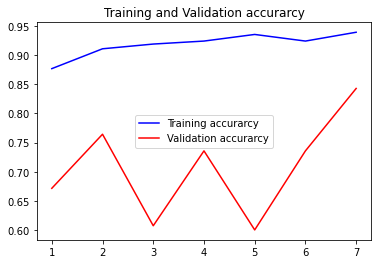

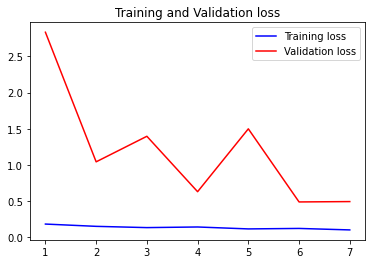

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [14]:
print("Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

Calculating model accuracy
5/5 [==============================] - 2s 452ms/step - loss: 1.7530 - accuracy: 0.7357
Test Accuracy: 73.57142567634583


In [20]:
#SAVE MODEL TO COMPUTER
model.save(root_directory + r"\project_model.h5")

In [21]:
#LOAD MODEL FROM COMPUTER
model = keras.models.load_model(root_directory + r"\project_model.h5")

In [22]:
def choose_rand_image(directory):
    image_pred5_list = listdir(directory)    
    return (directory + '\\' + random.choice(image_pred5_list))

In [23]:
def pred_image(image):
    im=convert_image_to_array(image)
    np_image_li = np.array(im, dtype=np.float16)
    npp_image = np.expand_dims(np_image_li, axis=0)
    result=model.predict(npp_image)
    
    print(image)
    print(result)
    itemindex = np.where(result==np.max(result))
    prob = np.max(result)
    print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])
    print()
    
    data = plt.imread(image)
    plt.imshow(data)
    plt.show()
    print()
        
    return(result, prob)

In [24]:
image_pred1 = root_directory + r"\!testdata\poison_ivy\IMG_4627.jpg"
image_pred2 = root_directory + r"\!testdata\potato\ef7005dc-1d44-412e-b858-145a2d7a6fa9___RS_HL 1951.JPG"
image_pred3 = root_directory + r"\!testdata\raspberry\IMG_4689.jpg"
image_pred4 = root_directory + r"\!testdata\tomato\6da1cf1b-a236-4d45-a390-dac6b65c45f7___GH_HL Leaf 264.JPG"
# image_pred5 = choose_rand_image(root_directory + r"\!testdata\!random")

# print(image_pred5)
# print(choose_rand_image(r"C:\Users\marti\Downloads\data_all\data_all\!testdata\!random"))

C:\Users\marti\Downloads\data_all\data_all\!testdata\poison_ivy\IMG_4627.jpg
[[1.0000000e+00 1.0485985e-08 4.7194565e-10]]
probability:1.0
poison_ivy



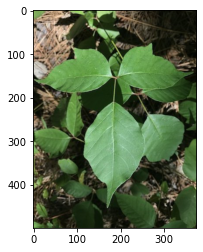


C:\Users\marti\Downloads\data_all\data_all\!testdata\potato\ef7005dc-1d44-412e-b858-145a2d7a6fa9___RS_HL 1951.JPG
[[2.7100106e-14 1.3036079e-17 1.0000000e+00]]
probability:1.0
tomato



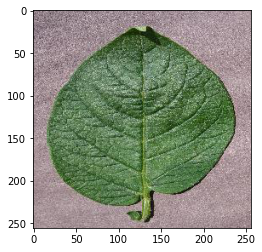


C:\Users\marti\Downloads\data_all\data_all\!testdata\raspberry\IMG_4689.jpg
[[9.6732336e-01 3.2676507e-02 7.7481516e-08]]
probability:0.96732336
poison_ivy



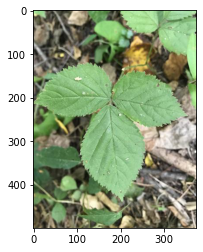


C:\Users\marti\Downloads\data_all\data_all\!testdata\tomato\6da1cf1b-a236-4d45-a390-dac6b65c45f7___GH_HL Leaf 264.JPG
[[6.1307937e-02 3.3864940e-06 9.3868864e-01]]
probability:0.93868864
tomato



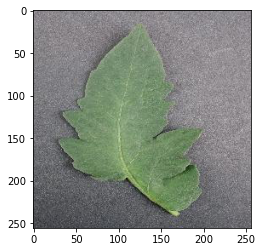

In [25]:
pred_image(image_pred1);
pred_image(image_pred2);
pred_image(image_pred3);
pred_image(image_pred4);

C:\Users\marti\Downloads\data_all\data_all\!testdata\!random\6e41f26a-5ce7-4fba-9fb5-e6a886b55f75___GH_HL Leaf 230.JPG
[[2.4366004e-03 1.4133768e-06 9.9756193e-01]]
probability:0.99756193
tomato



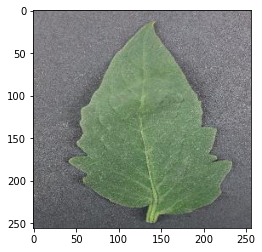

In [26]:
#RANDOM PICTURE SELECTED AND PREDICTED
image_pred5 = choose_rand_image(root_directory + r"\!testdata\!random")
pred_image(image_pred5);

In [27]:
def ran_prob_dist():
    prob_list = []
    img_count = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    
    for x in range (0, 15):
        rand_image_pred = choose_rand_image(root_directory + r"\!testdata\!random")
        result, prob = pred_image(rand_image_pred)
        prob_list.append(prob)
        #img_count += 1
    
    #print(prob_list, img_count)
    
#     print("Probability Distribution:")
    
    plt.scatter(img_count, prob_list)
    plt.xlabel("Image")
    plt.ylabel("Probability of Accuracy")
    plt.title("Probability Distribution")
    plt.show()

C:\Users\marti\Downloads\data_all\data_all\!testdata\!random\IMG_4695.jpg
[[2.3978777e-01 7.6021188e-01 3.7721568e-07]]
probability:0.7602119
raspberry



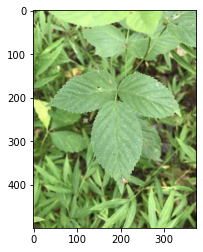


C:\Users\marti\Downloads\data_all\data_all\!testdata\!random\6e48af01-e836-4cdd-9b99-867d421c2ff3___RS_HL 9760.JPG
[[1.0792840e-07 1.4244177e-12 9.9999988e-01]]
probability:0.9999999
tomato



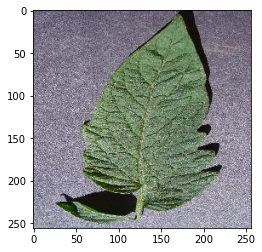


C:\Users\marti\Downloads\data_all\data_all\!testdata\!random\IMG_4697.jpg
[[2.3411104e-01 7.6588863e-01 4.0774566e-07]]
probability:0.76588863
raspberry



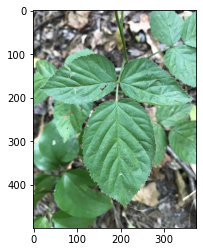


C:\Users\marti\Downloads\data_all\data_all\!testdata\!random\IMG_4627.jpg
[[1.0000000e+00 1.0485985e-08 4.7194565e-10]]
probability:1.0
poison_ivy



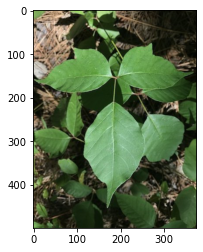


C:\Users\marti\Downloads\data_all\data_all\!testdata\!random\IMG_4689.jpg
[[9.6732336e-01 3.2676507e-02 7.7481516e-08]]
probability:0.96732336
poison_ivy



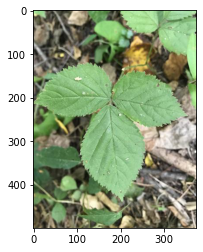


C:\Users\marti\Downloads\data_all\data_all\!testdata\!random\IMG_4634.jpg
[[9.9999988e-01 6.3476037e-08 2.1393259e-14]]
probability:0.9999999
poison_ivy



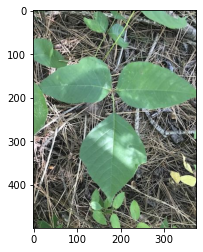


C:\Users\marti\Downloads\data_all\data_all\!testdata\!random\IMG_4689.jpg
[[9.6732336e-01 3.2676507e-02 7.7481516e-08]]
probability:0.96732336
poison_ivy



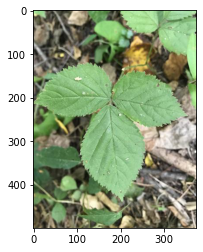


C:\Users\marti\Downloads\data_all\data_all\!testdata\!random\fd92bd9c-02cb-4599-8673-9316159504a1___RS_HL 1927.JPG
[[1.3986552e-13 9.6973615e-16 1.0000000e+00]]
probability:1.0
tomato



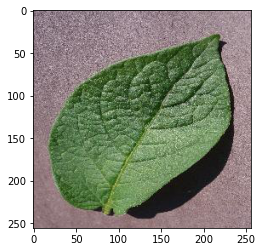


C:\Users\marti\Downloads\data_all\data_all\!testdata\!random\6e1abdb8-4020-48c9-9488-2d320e8d5a4d___RS_HL 0168.JPG
[[9.5348219e-13 1.9798047e-16 1.0000000e+00]]
probability:1.0
tomato



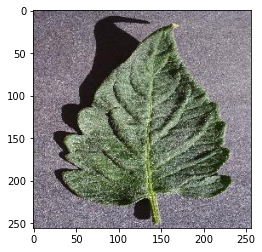


C:\Users\marti\Downloads\data_all\data_all\!testdata\!random\IMG_4630.jpg
[[9.9999738e-01 2.1629003e-06 5.1667155e-07]]
probability:0.9999974
poison_ivy



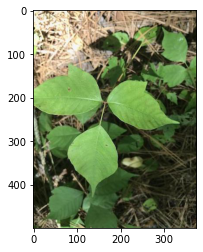


C:\Users\marti\Downloads\data_all\data_all\!testdata\!random\IMG_4695.jpg
[[2.3978777e-01 7.6021188e-01 3.7721568e-07]]
probability:0.7602119
raspberry



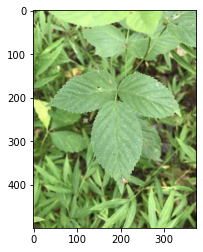


C:\Users\marti\Downloads\data_all\data_all\!testdata\!random\6dde71bb-a416-41eb-a629-7b4541e85cfc___RS_HL 9734.JPG
[[1.7895097e-03 2.6110913e-06 9.9820793e-01]]
probability:0.9982079
tomato



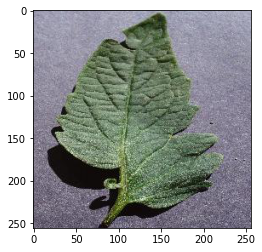


C:\Users\marti\Downloads\data_all\data_all\!testdata\!random\6e1abdb8-4020-48c9-9488-2d320e8d5a4d___RS_HL 0168.JPG
[[9.5348219e-13 1.9798047e-16 1.0000000e+00]]
probability:1.0
tomato



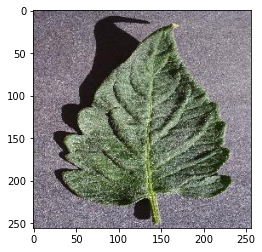


C:\Users\marti\Downloads\data_all\data_all\!testdata\!random\IMG_4637.jpg
[[9.9999809e-01 1.8947384e-06 1.3082467e-12]]
probability:0.9999981
poison_ivy



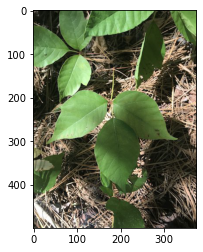


C:\Users\marti\Downloads\data_all\data_all\!testdata\!random\6e48af01-e836-4cdd-9b99-867d421c2ff3___RS_HL 9760.JPG
[[1.0792840e-07 1.4244177e-12 9.9999988e-01]]
probability:0.9999999
tomato



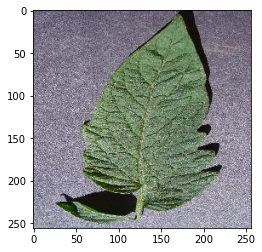

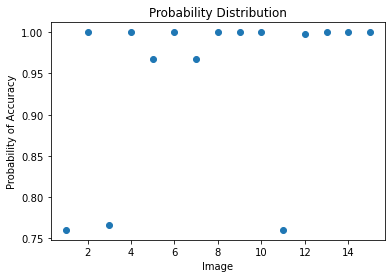

In [28]:
ran_prob_dist()

Example image has shape:  (256, 256, 3)
RGB values for the top left pixel are: [100  95 117]


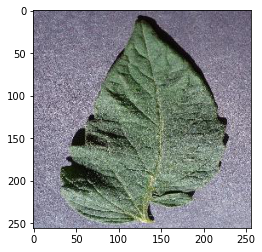

In [29]:
# load an image and explore
example_image = plt.imread(choose_rand_image(root_directory + r"\!testdata\!random"))

# show image
# ... YOUR CODE FOR TASK 3 ...
plt.imshow(example_image)
# print shape
print('Example image has shape: ', example_image.shape)
                    
# print color channel values for top left pixel
print('RGB values for the top left pixel are:', example_image[0,0])

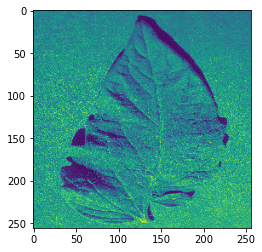

In [30]:
bw_ex = tf.image.rgb_to_grayscale(example_image)
plt.imshow(bw_ex)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


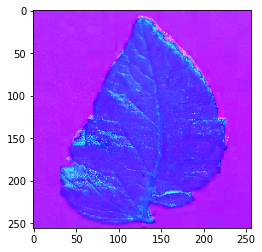

In [31]:
bw_ex = tf.image.rgb_to_hsv(example_image)
plt.imshow(bw_ex)

C:\Users\marti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


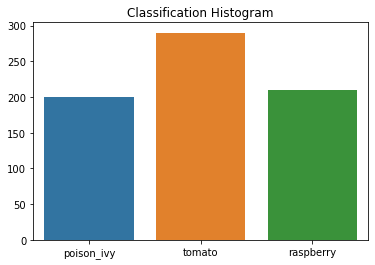

In [33]:
import seaborn as sns

labels = ['poison_ivy','tomato','raspberry']
count = [label_list.count('poison_ivy'),label_list.count('tomato'),label_list.count('raspberry')]
sns.barplot(labels, count)
plt.title("Classification Histogram")
plt.show()

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Dense(2, input_dim=1, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
